In [1]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx

import meshplot as mp
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from src import shapes

# Define The Figure and the Morse Function

In [2]:
def get_linear_morse(vector=None):
    if vector is None:
        vector = np.random.random(4)
    vector = np.array(vector)
    def f(points):
        return points @ vector
    return f

direction = np.random.random(3)
direction /= np.linalg.norm(direction)

In [3]:
f = lambda p: np.linalg.norm(p, axis=-1, ord=2)
f_linear = lambda p: p[:, 1]
#f = lambda p: (np.random.random(3)*p).sum(axis=-1)*(np.random.random(3)*p).sum(axis=-1)

In [4]:
def cylindrical_twist(vertices, k=1.0, mode="x", scale=1.0):
    """
    Nonlinear cylindrical twist diffeomorphism on R^3.

    vertices: (n,3) array
    mode:
      - "z": angle depends on z  (theta = k * tanh(z/scale))
      - "r": angle depends on radius r (theta = k * tanh(r/scale))
    k: twist strength (radians, roughly bounded by +/-k for tanh)
    scale: controls how quickly tanh saturates
    """
    if mode == 'x':
        v = vertices[:, [1, 2, 0]]
        v = cylindrical_twist(v, k=k, mode="z", scale=scale)
        v = v[:, [2, 0, 1]]
        return v
        
        
    v = vertices.copy()
    x, y, z = v[:, 0], v[:, 1], v[:, 2]

    r = np.sqrt(x*x + y*y)

    if mode == "z":
        theta = k * np.tanh(z / scale)
    elif mode == "r":
        theta = k * np.tanh(r / scale)
    else:
        raise ValueError('mode must be "z" or "r"')

    c, s = np.cos(theta), np.sin(theta)

    v[:, 0] = c * x - s * y
    v[:, 1] = s * x + c * y
    
    return v

In [5]:
n, m = 13, 12
vertices, faces = shapes.get_halftori_bouquet(leaves=3, n=n, m=m, l0=0.9, glue=False)

vertices = cylindrical_twist(vertices, k=-0.3, scale=1.5, mode='x')

vertices, faces = shapes.split_large_edges(vertices, faces, max_length=1.0)


print(f'faces.shape = {faces.shape}')

face_mean_values = f_linear(vertices[faces]).mean(axis=1)

p = mp.plot(vertices, faces, face_mean_values, shading={"wireframe": True})

faces.shape = (1282, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.70…

In [6]:
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3, dtype=faces.dtype), faces]).ravel()

mesh = pv.PolyData(vertices, faces_pv)
mesh.point_data["values"] = f_linear(vertices)  # per-vertex scalars

p = pv.Plotter(window_size=(600, 600))
p.add_mesh(
    mesh,
    scalars="values",
    cmap="viridis",
    smooth_shading=False,   # helps show linear interpolation nicely
    show_edges=True,      # set True if you want to see triangle edges
)
p.add_scalar_bar(title="values")
p.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700fb16e0710_0&reconnect=auto" class="pyvi…

# Paths

In [7]:
from src.ms import MorseSmale

In [8]:
ms = MorseSmale(faces, f(vertices), vertices, forest_method='steepest')
#ms = MorseSmale(faces, f(vertices), vertices, forest_method='spaning')

paths = list(ms.iterate_paths())

In [9]:
from src import vis
from src.vis import plot_paths, plot_segmentation_forests, plot_ms_comparition


In [10]:
pl = plot_paths(ms)
pl.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700f2c77faa0_1&reconnect=auto" class="pyvi…

In [11]:
pl = plot_segmentation_forests(ms, plot_complex=True,  point_size=16)
pl.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700f2c767770_2&reconnect=auto" class="pyvi…

In [12]:
ms0 =  MorseSmale(faces, f(vertices), vertices, forest_method='steepest')
ms1 =  MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')

ms0.define_critical_points()
ms1.define_critical_points()

In [13]:
pl = plot_ms_comparition([ms0, ms1], plot_segmentation_forests=False)
pl.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700f2c660c20_3&reconnect=auto" class="pyvi…

In [14]:
#ms =  MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')
ms =  MorseSmale(faces, f(vertices), vertices, forest_method='steepest')

In [15]:
faces_components = ms.define_decomposition_by_paths()
pd.Series(faces_components).value_counts().sort_index()

0     104
1     106
2     107
3     107
4      68
5      85
6      39
7      22
8     109
9     104
10    109
11    108
12     22
13     39
14     85
15     68
Name: count, dtype: int64

In [16]:
new_mesh = vis.get_pv_mesh(ms.vertices, ms.faces)
new_mesh.cell_data['component'] = ms.define_decomposition_by_paths()


pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, scalars="component", cmap="rainbow", smooth_shading=False, show_edges=True, categories=True)
for path in ms.get_paths():
    pl.add_mesh(pv.lines_from_points(vertices[path]), color='white', line_width=4)

pl.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700f2c77e150_4&reconnect=auto" class="pyvi…

In [17]:
chain = ms.get_paths()[0]

new_mesh = vis.get_pv_mesh(ms.vertices, ms.faces)
new_mesh.cell_data['distance from chain'] = ms.get_face_distances_from_chain(chain)


pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, scalars="distance from chain", cmap="turbo", smooth_shading=False, show_edges=True, categories=True)
pl.add_mesh(pv.lines_from_points(vertices[chain]), color='orangered', line_width=4)

pl.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700f2c6612b0_5&reconnect=auto" class="pyvi…

In [18]:
crytical_type_colors_dict = {'min': 'lime', 'max': 'red', 'saddle': 'yellow', 'regular': 'lightgrey'}

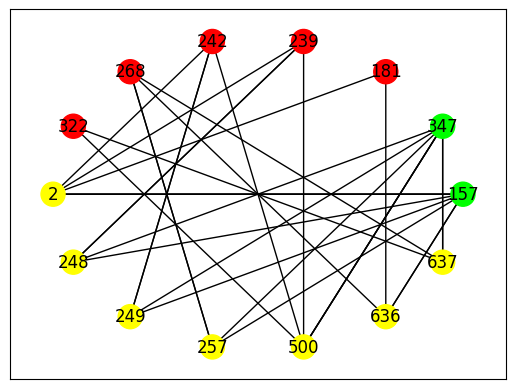

In [19]:


geodesics_graph = ms.get_geodesics_graph()

pos = nx.circular_layout(geodesics_graph)
node_colors = pd.DataFrame([data for node, data in geodesics_graph.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values


nx.draw_networkx(geodesics_graph, pos=pos, node_color=node_colors)

In [20]:
node_colors

array(['#00ff00', '#00ff00', '#ff0000', '#ff0000', '#ff0000', '#ff0000',
       '#ff0000', '#ffff00', '#ffff00', '#ffff00', '#ffff00', '#ffff00',
       '#ffff00', '#ffff00'], dtype=object)

In [35]:
pl = pv.Plotter(window_size=(600, 600))
#pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, categories=True)

for critical_type, color in crytical_type_colors_dict.items():
    pts = ms.vertices[[node for node, data in geodesics_graph.nodes(data=True) if critical_type == data['critical_type']]]
    if len(pts) > 0:
        pl.add_mesh(pts, color=color, point_size=12, render_points_as_spheres=True)

for e0, e1, data in geodesics_graph.edges(data=True):
    pl.add_mesh(pv.lines_from_points(data['geopath']), color='midnightblue', line_width=2)

pl.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700f18128b90_9&reconnect=auto" class="pyvi…

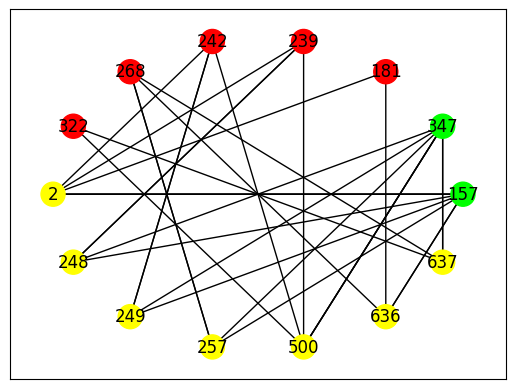

In [27]:
path_graph = ms.get_paths_graph()

pos = nx.circular_layout(path_graph)
node_colors = pd.DataFrame([data for node, data in path_graph.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values


nx.draw_networkx(path_graph, pos=pos, node_color=node_colors)

In [30]:
def concatenate_paths(path0, path1):
    """
    Concatenate two paths, allowing automatic reversal
    if endpoints match in opposite orientation.
    """

    if len(path0) == 0:
        return path1
    if len(path1) == 0:
        return path0

    if np.array_equal(path0[-1], path1[0]):
        return np.concatenate([path0[:-1], path1])

    if np.array_equal(path0[-1], path1[-1]):
        return np.concatenate([path0[:-1], path1[::-1]])

    if np.array_equal(path0[0], path1[-1]):
        return np.concatenate([path1[:-1], path0])

    if np.array_equal(path0[0], path1[0]):
        return np.concatenate([path1[::-1][:-1], path0])

    raise ValueError("Paths do not share endpoints.")

In [145]:
def make_cancellation(graph: nx.MultiGraph, values, node0, node1=None):
    """
    Makes the cancellation of birth-death pair in the paths graph.

    Pramaters:
    ----------
    graph: nx.MultiGraph
        Multigraph
        Nodes should have 'critical_type' attribute with values: 'max', 'min' or 'saddle'.
        This function should be sed in the mothod MorseSmale.get_paths_graph, and also applyable to the resulting graph.

    values: array

    node0: int
        The index of the canceling vertex.
        This expect to be local maxima or minima and the coresponding node in the graph expect to have degree 1 or 2.

    node1: int
        The index of the saddle, paired with canceling vertex

    """
    if (graph.degree(node0) not in [1, 2]) or (graph.nodes[node0].get('critical_type') not in ['min', 'max']):
        raise ValueError('node0 expect to be an index of local maxima or minima degree 1 or 2.')
    if node1 is None:
        neighbors = list(graph.neighbors(node0))
        neighbors_vals = np.array([values[node] for node in neighbors])
        node1 = neighbors[np.argmin(abs(neighbors_vals - values[node0]))]
    if graph.nodes[node1].get('critical_type') != 'saddle':
        raise ValueError('node1 expect to be an index of saddle')
    

    if graph.degree(node1) == 4:
        
        graph_after = graph.copy()
        graph_after.remove_nodes_from([node0, node1])

        if graph.degree(node0) == 2:
            new_path = [data['path'] for u, v, key, data in graph.edges(node1, keys=True, data=True) if graph.nodes[v].get('critical_type') == graph.nodes[node0].get('critical_type')]
            new_path = concatenate_paths(*new_path)

            new_edge_node0 = [node for node in graph.neighbors(node0) if node != node1][0]
            new_edge_node1 = [v for u, v, key, data in graph.edges(node1, keys=True, data=True) if graph.nodes[v].get('critical_type') == graph.nodes[node0].get('critical_type')]
            new_edge_node1 = [v for v in new_edge_node1 if v != node0][0]
            graph_after.add_edge(new_edge_node0, new_edge_node1, path=new_path)

        return graph_after
    
    raise ValueError('Not yet solved case with a monkey saddle')

In [146]:
path_graph_after = make_cancellation(path_graph, ms.values, 181)

path_graph_after

In [147]:
pl = pv.Plotter(window_size=(600, 600))
#pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, categories=True)

for critical_type, color in crytical_type_colors_dict.items():
    pts = ms.vertices[[node for node, data in path_graph_after.nodes(data=True) if critical_type == data['critical_type']]]
    if len(pts) > 0:
        pl.add_mesh(pts, color=color, point_size=12, render_points_as_spheres=True)

for e0, e1, data in path_graph_after.edges(data=True):
    pl.add_mesh(pv.lines_from_points(ms.vertices[data['path']]), color='midnightblue', line_width=2)

pl.show()

Widget(value='<iframe src="http://localhost:41617/index.html?ui=P_0x700f181c8890_16&reconnect=auto" class="pyv…

In [22]:
assert False

AssertionError: 

In [ ]:
faces = np.array([[ 0,  1, 13], 
                  [12, 13,  1], 
                  [ 1,  2, 12], 
                  [ 2,  3, 11], 
                  [ 3,  4, 10], 
                  #[4, 5, 10],
                  [ 5,  6,  9], 
                  [ 6,  9,  8], 
                  [ 6,  7,  8]])
chain = np.arange(8)


In [ ]:
def get_faces_components(faces):
    """
    """
    if (faces.ndim != 2) or (faces.shape[-1] != 3):
        raise ValueError(f'Expected faces be shape (n, 3)')
    g = nx.Graph()
    g.add_nodes_from(range(faces.shape[0]))
    g.add_edges_from([(i, j) for i, j in itertools.combinations(range(faces.shape[0]), 2) if np.intersect1d(faces[i], faces[j]).size == 2])
    return  list(map(lambda i: faces[list(i)], nx.connected_components(g)))

def iterate_chain_comonent_parts(faces, chain):
    """
    """
    if faces.size == 0:
        pass
    faces_components = get_faces_components(faces)
    edge_component_sets = np.transpose([np.isin(chain[:-1], comp) & np.isin(chain[1:], comp) for comp in faces_components])
    print(edge_component_sets)
    edge_components = np.append(0, ((~(edge_component_sets[1:] == edge_component_sets[:-1]).all(axis=1)) & edge_component_sets[:-1].any()).cumsum())
    
    print(edge_components)
    for i in np.unique(edge_components):
        print(i, np.argwhere(edge_components == i)[:, 0])
        p0 = np.argwhere(edge_components == i)[:, 0].min()
        p1 = np.argwhere(edge_components == i)[:, 0].max() + 1
        
        edge_comp = edge_component_sets[p0]
        if not edge_comp.any():
            comp_faces = None
        else:
            assert edge_comp.sum() == 1

            comp_faces = faces_components[np.argwhere(edge_comp)[0, 0]]
        yield p0, p1, comp_faces

In [ ]:
list(iterate_chain_comonent_parts(np.array([[1, 2, 3]]), chain))

In [ ]:
faces_components = get_faces_components(faces)

faces_components

In [ ]:
chain

In [ ]:
assert False

In [ ]:
path_index = -2
path = ms.get_paths()[path_index]

pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, categories=True)
for chain in ms.get_paths():
    pl.add_mesh(pv.lines_from_points(vertices[chain]), color='midnightblue', line_width=6)


pl.add_mesh(pv.lines_from_points(vertices[path]), color='crimson', line_width=6)

pl.show()

In [ ]:
def get_surrounding_faces(self: MorseSmale, chain, level=0):
    """
    """
    if level == 0:
        faces_vertex_permutations = self.faces[:, [list(perm) for perm in itertools.permutations(range(3), 2)]][..., None]
        chain_edges = np.array([chain[:-1], chain[1:]])
        surrounding_faces = np.argwhere((faces_vertex_permutations == chain_edges).all(axis=-2).any(axis=(-1, -2))).reshape(-1)
        return surrounding_faces
    surrounding_faces = get_surrounding_faces(self, chain, level=level-1)
    add_faces = np.unique([list(self.get_face_graph().neighbors(node)) for node in surrounding_faces])
    surrounding_faces = np.unique(np.concatenate([surrounding_faces, add_faces]))
    return add_faces

In [ ]:
def get_surrounding_faces(self: MorseSmale, chain, level=0):
    """
    """
    faces_vertex_permutations = self.faces[:, [list(perm) for perm in itertools.permutations(range(3), 2)]][..., None]
    chain_edges = np.array([chain[:-1], chain[1:]])
    surrounding_faces0 = np.argwhere((faces_vertex_permutations == chain_edges).all(axis=-2).any(axis=(-1, -2))).reshape(-1)
    dist = nx.multi_source_dijkstra_path_length(self.get_face_graph(), sources=set(surrounding_faces0))
    surrounding_faces = np.array([key for key, value in dist.items() if value <= level])
    return surrounding_faces

In [ ]:
def get_face_distances_from_chain(self: MorseSmale, chain):
    """
    """
    faces_vertex_permutations = self.faces[:, [list(perm) for perm in itertools.permutations(range(3), 2)]][..., None]
    chain_edges = np.array([chain[:-1], chain[1:]])
    surrounding_faces0 = np.argwhere((faces_vertex_permutations == chain_edges).all(axis=-2).any(axis=(-1, -2))).reshape(-1)
    dist = nx.multi_source_dijkstra_path_length(self.get_face_graph(), sources=set(surrounding_faces0))
    dist = np.array([dist[i] for i in range (self.n_faces)])

    return dist


In [ ]:
def get_face_distances_from_chain(self: MorseSmale, chain):
    """
    """
    faces_vertex_permutations = self.faces[:, [list(perm) for perm in itertools.permutations(range(3), 2)]][..., None]
    chain_edges = np.array([chain[:-1], chain[1:]])
    surrounding_faces0 = np.argwhere((faces_vertex_permutations == chain_edges).all(axis=-2).any(axis=(-1, -2))).reshape(-1)
    dist = nx.multi_source_dijkstra_path_length(self.get_face_graph(), sources=set(surrounding_faces0))
    dist = np.array([dist[i] for i in range (self.n_faces)])
    return dist


In [ ]:
def get_vertex_distances_from_chain(self: MorseSmale, chain):
    """
    """
    face_distances_from_chain = get_face_distances_from_chain(self, chain)
    dist = nx.multi_source_dijkstra_path_length(self.get_edge_graph(), sources=set(chain))
    dist = np.array([dist[i] for i in range (self.n_vertices)])
    return dist
    


In [ ]:
def get_cuting_edges_surroounding_chain(self: MorseSmale, chain):
    """
    """
    graph01 = self.get_edge_graph()
    graph12 = self.get_face_graph()
    
    dists0 = get_vertex_distances_from_chain(self, chain)
    dists2 = get_face_distances_from_chain(self, chain)

    weights01 = {(e0, e1): dists0[[e0, e1]].max() for e0, e1 in graph01.edges()}
    weights12 = {(e0, e1): dists2[[e0, e1]].max() for e0, e1 in graph12.edges()}

    nx.set_edge_attributes(graph01, weights01, 'weight')
    nx.set_edge_attributes(graph12, weights12, 'weight')

    edges01 = np.array(list(nx.minimum_spanning_tree(graph01, weight='weight').edges))
    edges12 = np.array([data['intersection'] for e0, e1, data in nx.minimum_spanning_tree(graph12, weight='weight').edges(data=True)])
    
    edges = np.array(list(np.array(graph01.edges())))

    edges_to_cut = set(map(tuple, edges)) - set(map(tuple, edges01)) - set(map(tuple, edges12))
    edges_to_cut = np.array(list(edges_to_cut))
    return edges_to_cut

In [ ]:
def get_cuting_edges_surroounding_chain(self: MorseSmale, chain):
    """
    """
    graph01 = self.get_edge_graph()
    graph12 = self.get_face_graph()
    
    dists0 = get_vertex_distances_from_chain(self, chain)
    dists2 = get_face_distances_from_chain(self, chain)

    weights01 = {(e0, e1): dists0[[e0, e1]].max() for e0, e1 in graph01.edges()}
    weights12 = {(e0, e1): dists2[[e0, e1]].min() for e0, e1 in graph12.edges()}

    nx.set_edge_attributes(graph01, weights01, 'weight')
    nx.set_edge_attributes(graph12, weights12, 'weight')

    tree01 = nx.minimum_spanning_tree(graph01, weight='weight')
    tree01_edges = set(map(tuple, tree01.edges()))

    graph12.remove_edges_from([(e0, e1) for e0, e1, data in graph12.edges(data=True) if tuple(data['intersection']) in tree01_edges])
    tree12 = nx.minimum_spanning_tree(graph12, weight='weight')
    tree12_edges = [data['intersection'] for e0, e1, data in nx.minimum_spanning_tree(tree12, weight='weight').edges(data=True)]
    tree12_edges = set(map(tuple, tree12_edges))


    edges = set(graph01.edges())
    edges_to_cut = set(map(tuple, edges)) - set(map(tuple, tree01_edges)) - set(map(tuple, tree12_edges))
    edges_to_cut = np.array(list(edges_to_cut))
    return edges_to_cut

In [ ]:
def get_cuting_edges_surroounding_chain(self: MorseSmale, chain):
    """
    """
    graph0 = self.get_edge_graph()
    dists0 = get_vertex_distances_from_chain(self, chain)
    weights0 = {(e0, e1): dists0[[e0, e1]].max() for e0, e1 in graph0.edges()}
    nx.set_edge_attributes(graph0, weights0, 'weight')
    tree0 = nx.minimum_spanning_tree(graph0, weight='weight')
    tree0_edges = set(map(tuple, tree0.edges()))

    graph1 = self.get_face_graph()
    remove_cond = lambda e0, e1: ((e0, e1) in tree0_edges) or ((e1, e0) in tree0_edges)
    graph1.remove_edges_from([(e0, e1) for e0, e1, data in graph1.edges(data=True) if remove_cond(*data['intersection'])])
    dists1 = get_face_distances_from_chain(self, chain)
    weights1 = {(e0, e1): dists1[[e0, e1]].max() for e0, e1 in graph1.edges()}
    nx.set_edge_attributes(graph1, weights1, 'weight')
    tree1 = nx.minimum_spanning_tree(graph1, weight='weight')
    tree1_edges = set(map(tuple, [data['intersection'] for e0, e1, data in tree1.edges(data=True)]))

    edges = set(weights0.keys())

    return edges - tree1_edges - tree0_edges

In [ ]:
def get_cuting_edges_surroounding_chain(self: MorseSmale, chain):
    """
    """
    def ordered_tuple(edge):
        a, b = edge
        return (a, b) if a <= b else (b, a)
    graph0 = self.get_edge_graph()
    dists0 = get_vertex_distances_from_chain(self, chain)
    weights0 = {(e0, e1): dists0[[e0, e1]].max() for e0, e1 in graph0.edges()}
    nx.set_edge_attributes(graph0, weights0, 'weight')
    tree0 = nx.minimum_spanning_tree(graph0, weight='weight')
    tree0_edges = set(map(ordered_tuple, tree0.edges()))

    #return tree0_edges

    graph1 = self.get_face_graph()
    graph1.remove_edges_from([(e0, e1) for e0, e1, data in graph1.edges(data=True) if ordered_tuple(data['intersection']) in tree0_edges])
    dists1 = get_face_distances_from_chain(self, chain)
    weights1 = {(e0, e1): dists1[[e0, e1]].max() for e0, e1 in graph1.edges()}
    nx.set_edge_attributes(graph1, weights1, 'weight')
    tree1 = nx.minimum_spanning_tree(graph1, weight='weight')

    tree1_edges = set(map(ordered_tuple, [data['intersection'] for e0, e1, data in tree1.edges(data=True)]))

    edges = set(map(ordered_tuple, weights0.keys()))

    initial_cut_edges = edges - tree1_edges - tree0_edges


    return initial_cut_edges

In [ ]:
get_face_distances_from_chain(ms, path).shape

In [ ]:
get_vertex_distances_from_chain(ms, path).shape

In [ ]:
get_cuting_edges_surroounding_chain(ms, path)

In [ ]:
cuting_graph = nx.Graph()
cuting_graph.add_edges_from(get_cuting_edges_surroounding_chain(ms, path))

In [ ]:
nx.number_connected_components(cuting_graph)

In [ ]:
len(nx.cycle_basis(cuting_graph))

In [ ]:
{}

In [ ]:
new_mesh.point_data[f'Vertex distance to path {path_index}'] = get_vertex_distances_from_chain(ms, path)
new_mesh.cell_data[f'Face distance to path {path_index}'] = get_face_distances_from_chain(ms, path)

pl = pv.Plotter(shape=(1, 2), window_size=(1200, 600))

pl.subplot(0, 0)
pl.add_mesh(new_mesh, scalars=f'Vertex distance to path {path_index}', cmap="turbo", smooth_shading=False, show_edges=True, categories=False)
pl.add_mesh(pv.lines_from_points(vertices[path]), color='orangered', line_width=6)

pos = {node: val for node, val in enumerate(ms.vertices)}
vis.add_graph_to_plotter(pl, cuting_graph, pos, node_color='white', edge_color='white')

pl.subplot(0, 1)
pl.add_mesh(new_mesh, scalars=f'Face distance to path {path_index}', cmap="turbo", smooth_shading=False, show_edges=True, categories=False)
pl.add_mesh(pv.lines_from_points(vertices[path]), color='orangered', line_width=6)


pl.link_views()
pl.show()

In [ ]:
def triangle_area(a, b, c):
    """
    """
    lab = np.linalg.norm(a - b, axis=-1)
    lac = np.linalg.norm(a - c, axis=-1)
    lbc = np.linalg.norm(b - c, axis=-1)
    s = 0.5*(lab + lac + lbc)
    area = (s*(s - lab)*(s - lac)*(s - lbc))**0.5
    return area


def get_face_distances_from_chain(self: MorseSmale, chain, weight_function='area'):
    """
    """
    if type(weight_function) is str:
        if weight_function == 'area':
            def fw(face0, face1, **kvars):
                a, b = self.vertices[np.intersect1d(face0, face1)]
                c0 = self.vertices[face0].mean(axis=0)
                c1 = self.vertices[face1].mean(axis=0)
                return triangle_area(a, b, c0) + triangle_area(a, b, c1)
        elif weight_function == 'length':
            def fw(face0, face1, **kvars):
                a, b = self.vertices[np.intersect1d(face0, face1)]
                return np.linalg.norm(a - b)
    if weight_function is None:
        weight_function = 'weight'
    else:
        weight_function = lambda u, v, args: fw(ms.faces[u], ms.faces[v]) if u != v else 0
    
    faces_vertex_permutations = self.faces[:, [list(perm) for perm in itertools.permutations(range(3), 2)]][..., None]
    chain_edges = np.array([chain[:-1], chain[1:]])
    surrounding_faces0 = np.argwhere((faces_vertex_permutations == chain_edges).all(axis=-2).any(axis=(-1, -2))).reshape(-1)
    dist = nx.multi_source_dijkstra_path_length(self.get_face_graph(), sources=set(surrounding_faces0), weight=weight_function)
    dist = np.array([dist[i] for i in range (self.n_faces)])
    return dist

In [ ]:
distances_from_chain_dict = {weight_function: get_face_distances_from_chain(ms, path, weight_function) for weight_function in [None, 'length', 'area']}

title_template = 'Face distance from path by {0}'
pl = pv.Plotter(shape=(1, len(distances_from_chain_dict)), window_size=(1200, 500))
for i, (key, value) in enumerate(distances_from_chain_dict.items()):
    title = title_template.format(key)
    
    mesh_i = new_mesh.copy(deep=True)
    mesh_i.cell_data[title] = value

    pl.subplot(0, i)
    pl.add_mesh(mesh_i, scalars=title, cmap="turbo", smooth_shading=False, show_edges=True, categories=False)
    pl.add_mesh(pv.lines_from_points(vertices[path]), color='orangered', line_width=6)
pl.link_views()
pl.show()

In [ ]:
def get_surrounding_disk(self: MorseSmale, chain, weight_function='area'):
    """
    """
    face_order = np.argsort(get_face_distances_from_chain(self, chain, weight_function))
    

In [ ]:
def get_surrounding_disk_cuts(self: MorseSmale, chain):
    """
    """
    pass

In [ ]:
get_surrounding_disk_cuts(ms, path)

In [ ]:
def compact_mesh(V, F):
    """
    Remove vertices not referenced by any face and reindex faces.
    Returns V2, F2, old2new, new2old.
    """
    V = np.asarray(V)
    F = np.asarray(F)

    used = np.zeros(len(V), dtype=bool)
    used[F.reshape(-1)] = True

    new2old = np.nonzero(used)[0]
    old2new = -np.ones(len(V), dtype=int)
    old2new[new2old] = np.arange(len(new2old))

    V2 = V[new2old]
    F2 = old2new[F]

    return V2, F2, old2new, new2old

In [ ]:
from pygeodesic import geodesic

In [ ]:
geo_paths = [ms.vertices[path]]
geo_distances = [np.linalg.norm(ms.vertices[path][1:] - ms.vertices[path][:-1], axis=1).sum()]

level = 1
while True:
    surrounding_faces = get_surrounding_faces(ms, path, level=level)

    V, F, old2new, new2old = compact_mesh(ms.vertices, ms.faces[surrounding_faces])
    source_vid = old2new[path[0]]
    target_vid = old2new[path[-1]]

    geo = geodesic.PyGeodesicAlgorithmExact(V, F)
    geo_distance, geopath = geo.geodesicDistance(source_vid, target_vid)

    if abs(geo_distances[-1] - geo_distance) <= 1e-6:
        break

    geo_paths.append(geopath)
    geo_distances.append(geo_distance)

    level += 1
    
geo_distances

In [ ]:
[geopath.shape for geopath in geo_paths]

In [ ]:
pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, categories=True)
for chain in ms.get_paths():
    pl.add_mesh(pv.lines_from_points(vertices[chain]), color='grey', line_width=6)

for i, geopath in enumerate(geo_paths):
    if geopath.size > 0:
        color = mcolors.to_hex(plt.get_cmap('inferno')(i/len(geo_paths)))
        pl.add_mesh(pv.lines_from_points(geopath), color=color, line_width=6)

pl.show()

In [ ]:
ms0 =  MorseSmale(faces, f(vertices), vertices, forest_method='steepest')
ms1 =  MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')

In [ ]:
max_level = 6

geopath_sets0 = []
for path in ms0.get_paths():
    geo_paths = [ms0.vertices[path]]
    geo_distances = [np.linalg.norm(geo_paths[-1][1:] - geo_paths[-1][:-1], axis=1).sum()]
    level = 1
    while True:
        surrounding_faces = get_surrounding_faces(ms0, path, level=level)

        V, F, old2new, new2old = compact_mesh(ms0.vertices, ms0.faces[surrounding_faces])
        source_vid = old2new[path[0]]
        target_vid = old2new[path[-1]]

        geo = geodesic.PyGeodesicAlgorithmExact(V, F)
        geo_distance, geopath = geo.geodesicDistance(source_vid, target_vid)

        if abs(geo_distances[-1] - geo_distance) <= 1e-6:
            break

        geo_paths.append(geopath)
        geo_distances.append(geo_distance)

        level += 1
    geopath_sets0.append(geo_paths)



geopath_sets1 = []
for path in ms1.get_paths():
    geo_paths = [ms1.vertices[path]]
    geo_distances = [np.linalg.norm(geo_paths[-1][1:] - geo_paths[-1][:-1], axis=1).sum()]
    level = 1
    while True:
        surrounding_faces = get_surrounding_faces(ms1, path, level=level)

        V, F, old2new, new2old = compact_mesh(ms1.vertices, ms1.faces[surrounding_faces])
        source_vid = old2new[path[0]]
        target_vid = old2new[path[-1]]

        geo = geodesic.PyGeodesicAlgorithmExact(V, F)
        geo_distance, geopath = geo.geodesicDistance(source_vid, target_vid)

        if abs(geo_distances[-1] - geo_distance) <= 1e-6:
            break

        geo_paths.append(geopath)
        geo_distances.append(geo_distance)

        level += 1
    geopath_sets1.append(geo_paths)

In [ ]:
pd.DataFrame({'Amount of geodesic variants for paths in case 0': pd.Series(map(len, geopath_sets0)).value_counts(), 
              'Amount of geodesic variants for paths in case 1': pd.Series(map(len, geopath_sets1)).value_counts()}).fillna(0).astype(int)

In [ ]:
pl = pv.Plotter(shape=(2, 2), window_size=(1200, 1000))

pl.subplot(0, 0)
vis.add_complex_to_plotter(pl, ms0, opacity=1.0, smooth_shading=False, show_edges=True,
                           with_values=True, data_title='values', color='white', value_cmap="viridis",
                           with_critical_points=True, min_color="lime", saddle_color="pink", max_color='orangered', point_size=12, 
                           with_paths=True, path_color='white', path_cmap=None, linewidth=4, eps=0.0)

pl.subplot(0, 1)
vis.add_complex_to_plotter(pl, ms1, opacity=1.0, smooth_shading=False, show_edges=True,
                           with_values=True, data_title='values', color='white', value_cmap="viridis",
                           with_critical_points=True, min_color="lime", saddle_color="pink", max_color='orangered', point_size=12, 
                           with_paths=True, path_color='white', path_cmap=None, linewidth=4, eps=0.0)


pl.subplot(1, 0)
pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, categories=True)
for geo_paths in geopath_sets0:
    for i, geopath in enumerate(geo_paths):
        if geopath.size > 0:
            color = mcolors.to_hex(plt.get_cmap('plasma')(i/(len(geo_paths) - 1)))
            pl.add_mesh(pv.lines_from_points(geopath), color=color, line_width=6)
vis.add_critical_points_to_plotter(pl, ms0)


pl.subplot(1, 1)
pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, categories=True)
for geo_paths in geopath_sets1:
    for i, geopath in enumerate(geo_paths):
        if geopath.size > 0:
            color = mcolors.to_hex(plt.get_cmap('plasma')(i/(len(geo_paths) - 1)))
            pl.add_mesh(pv.lines_from_points(geopath), color=color, line_width=6)
vis.add_critical_points_to_plotter(pl, ms1)

pl.link_views()
pl.show()

In [ ]:
def count_new_vertices(faces, new_face):
    """
    """
    vertices = np.unique(faces)
    cnt_vertices = np.sum(~np.isin(new_face, vertices))
    return cnt_vertices

def count_new_edges(faces, new_face):
    """
    """
    edges = np.vstack([
        faces[:, [0, 1]],
        faces[:, [1, 2]],
        faces[:, [2, 0]]
    ])
    edges = np.sort(edges, axis=1)

    new_edges = np.array([
        [new_face[0], new_face[1]],
        [new_face[1], new_face[2]],
        [new_face[2], new_face[0]]
    ])
    new_edges = np.sort(new_edges, axis=1)

    matches = (edges[:, None] == new_edges).all(axis=2)
    edge_exists = matches.any(axis=0)

    cnt_edges = np.sum(~edge_exists)

    return cnt_edges

def is_homotopy_preserving_face_addition(faces, new_face):
    """
    """
    if (np.sort(faces, axis=1) == np.sort(new_face)).all(axis=1).any():
        return False
    cnt_v = count_new_vertices(faces, new_face)
    if cnt_v == 3:
        return False
    cnt_e = count_new_edges(faces, new_face)
    return cnt_e - cnt_v == 1

In [ ]:
faces

In [ ]:
def edges_are_free(edges: np.ndarray) -> np.ndarray:
    """
    An edge is 'free' (collapsible as an edge–vertex pair) if it has
    at least one vertex of degree 1 (appears in exactly one edge).
    edges: (m, 2)
    returns: (m,) bool
    """
    edges = np.asarray(edges)
    vertices, counts = np.unique(edges, return_counts=True)
    lonely_vertices = vertices[counts == 1]
    # edge is free if it contains exactly one lonely vertex (a leaf edge)
    edges_status = np.isin(edges, lonely_vertices).sum(axis=1) == 1
    return edges_status


def faces_are_free(faces: np.ndarray):
    """
    A face is 'free' (collapsible as a face–edge pair) if it contains
    exactly one edge that belongs to exactly one face.

    faces: (n, 3) triangles with vertex indices
    returns:
      faces_status: (n,) bool
      free_edges: (k, 2) array of free edges (vertex pairs, sorted)
    """
    faces = np.asarray(faces)

    # All triangle edges with multiplicity: (3n, 2)
    all_edges = np.concatenate(
        [faces[:, [0, 1]], faces[:, [0, 2]], faces[:, [1, 2]]],
        axis=0
    )
    all_edges = np.sort(all_edges, axis=1)

    # Count how many faces each edge belongs to
    uniq_edges, edge_counts = np.unique(all_edges, axis=0, return_counts=True)
    free_edges = uniq_edges[edge_counts == 1]

    # For each face, count how many of its 3 edges are free
    face_edges = np.stack(
        [np.sort(faces[:, [0, 1]], axis=1),
         np.sort(faces[:, [0, 2]], axis=1),
         np.sort(faces[:, [1, 2]], axis=1)],
        axis=1
    )  # (n, 3, 2)

    faces_status = np.isin(face_edges.reshape(-1, 2), free_edges).all(axis=1)\
                    .reshape(faces.shape[0], 3).sum(axis=1) == 1

    return faces_status, free_edges

In [ ]:
import numpy as np

def _row_view(a: np.ndarray) -> np.ndarray:
    """View a 2D array as 1D rows (bytes) so we can do row-wise isin."""
    a = np.ascontiguousarray(a)
    return a.view(np.dtype((np.void, a.dtype.itemsize * a.shape[1]))).ravel()

def _face_edges(faces: np.ndarray) -> np.ndarray:
    """All edges of all faces with multiplicity: (3n, 2), sorted within each edge."""
    e = np.concatenate([faces[:, [0, 1]], faces[:, [0, 2]], faces[:, [1, 2]]], axis=0)
    return np.sort(e, axis=1)

def collapse_faces_while_possible(
    faces: np.ndarray,
    *,
    require_exactly_one_free_edge: bool = False,
    return_history: bool = False,
):
    """
    Iteratively collapse triangular faces by removing any face that has a free edge.
    Free edge = belongs to exactly one face.

    If require_exactly_one_free_edge=True, remove a face only if it has *exactly one* free edge.
    Otherwise (default), remove a face if it has *at least one* free edge (common in practice).

    Returns:
      faces_new (and optionally history: list of removed-face masks per iteration).
    """
    faces = np.asarray(faces)
    history = []

    while True:
        if len(faces) == 0:
            break

        all_edges = _face_edges(faces)  # (3n, 2) with multiplicity
        uniq_edges, edge_counts = np.unique(all_edges, axis=0, return_counts=True)
        free_edges = uniq_edges[edge_counts == 1]  # (k, 2)

        if len(free_edges) == 0:
            break

        # Count free edges per face
        fe = np.stack(
            [np.sort(faces[:, [0, 1]], axis=1),
             np.sort(faces[:, [0, 2]], axis=1),
             np.sort(faces[:, [1, 2]], axis=1)],
            axis=1
        )  # (n, 3, 2)

        # row-wise membership: (n*3,) bool
        fe_rows = _row_view(fe.reshape(-1, 2))
        free_rows = _row_view(free_edges)
        is_free = np.isin(fe_rows, free_rows).reshape(len(faces), 3)

        free_cnt = is_free.sum(axis=1)
        if require_exactly_one_free_edge:
            remove_mask = (free_cnt == 1)
        else:
            remove_mask = (free_cnt >= 1)

        if not np.any(remove_mask):
            break

        if return_history:
            history.append(remove_mask.copy())

        faces = faces[~remove_mask]

    return (faces, history) if return_history else faces


In [ ]:
def is_collapsible(faces) -> bool:
    """
    """
    g = nx.Graph()
    g.add_edges_from(np.concatenate(faces[:, [[0, 1], [0, 2], [1, 2]]]))
    if nx.number_connected_components(g) != 1:
        return False
    collapsed = collapse_faces_while_possible(faces)
    return collapsed.size == 0

In [ ]:
import itertools

faces_disk = np.array([[0, 1, 2],
                       [0, 2, 3], 
                       [0, 3, 4], 
                       [0, 1, 4], 
                       [0, 1, 5]
                       ])
faces_sphere = np.array(list(itertools.combinations(range(4), 3)) + [[0, 1, 9]])
faces_cylinder = np.array([[0, 1, 2], 
                           [1, 2, 3], 
                           [2, 3, 4], 
                           [3, 4, 5], 
                           [4, 5, 0], 
                           [0, 1, 8]])

is_collapsible(faces_disk), is_collapsible(faces_sphere), is_collapsible(faces_cylinder)

In [ ]:
path

In [ ]:
ms.faces[(ms.faces[:, [list(perm) for perm in itertools.permutations(range(3), 2)]][..., None] == np.array([path[:-1], path[1:]])).all(axis=-2).any(axis=(-1, -2))]

In [ ]:
def compact_mesh(V, F):
    """
    Remove vertices not referenced by any face and reindex faces.
    Returns V2, F2, old2new, new2old.
    """
    V = np.asarray(V)
    F = np.asarray(F)

    used = np.zeros(len(V), dtype=bool)
    used[F.reshape(-1)] = True

    new2old = np.nonzero(used)[0]
    old2new = -np.ones(len(V), dtype=int)
    old2new[new2old] = np.arange(len(new2old))

    V2 = V[new2old]
    F2 = old2new[F]

    return V2, F2, old2new, new2old

In [ ]:
V2, F2, old2new, new2old = compact_mesh(vertices, surrounding)

start_idx = old2new[path[0]]
end_idx = old2new[path[-1]]

In [ ]:
F2_pv = np.hstack([np.full((surrounding.shape[0], 1), 3, dtype=faces.dtype), F2]).ravel()

part_mesh = pv.PolyData(V2, F2_pv)

pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(part_mesh, color='white', smooth_shading=False, show_edges=True)
pl.show()